In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # to display images in a specific colormap

import scipy.optimize as optimize
from scipy.io import loadmat
from scipy.special import expit # sigmoid function

import pandas as pd
import random
import itertools
from PIL import Image

In [2]:
# read data
mat = loadmat('ex4data1.mat')
X, Y = mat['X'], mat['y']

X = np.insert(X, 0, 1, axis=1)

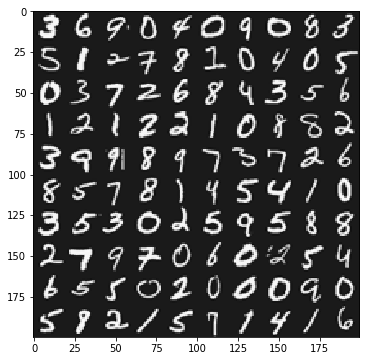

In [3]:
# 将一行row的数据转化成20x20的数据，作为small_pic的信息
def getSmallImage(row): 
    height, width = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

def displayData(indices_to_display=None):
    
    width, height = 20, 20
    g_rows, g_cols = 10, 10
    
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), g_rows*g_cols)
    
    big_pic = np.zeros((height*g_rows, width*g_cols))
    
    i_row, i_col = 0, 0
    for idx in indices_to_display:
        if i_col == g_cols:
            i_row += 1
            i_col = 0
        
        small_img = getSmallImage(X[idx])
        big_pic[i_row*height:i_row*height+small_img.shape[0], i_col*width:i_col*width+small_img.shape[1]] = small_img
        
        i_col += 1
    
    fig = plt.figure(figsize=(6,6))
    img = Image.fromarray(big_pic)
    plt.imshow(img, cmap=cm.Greys_r)
                                           
displayData()
                                        
    

In [4]:
# model representation

# read weights ø
mat2 = loadmat('ex4weights.mat')
Theta1, Theta2 = mat2['Theta1'], mat2['Theta2']

# global variables
input_layer_size = 400 # 20x20
hidden_layer_size = 25
output_layer_size = 10
no_training_samples = X.shape[0]

m = no_training_samples

In [5]:
# utility functin 公共用方法

# 生成一维数据 -> (n,1) shaped numpy array
def flattenParams(inital_list):
    # 循环取出list中元素
    flattened_list = [element.flatten() for element in inital_list]
    # 重新组成list，一维
    combined = list(itertools.chain.from_iterable(flattened_list))
    
    return np.array(combined)
    
def reshapeParams(flattened_array):
    term1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
                            .reshape((hidden_layer_size, input_layer_size+1))
    term2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
                            .reshape((output_layer_size, hidden_layer_size+1))
    
    return [term1, term2] # [theta1, theta2]

def flattenX(X):
    return np.array(X.flatten()).reshape((no_training_samples*(input_layer_size+1), 1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((no_training_samples, input_layer_size+1))


In [6]:
# 向前传播
def propagateForward(row, Thetas):
    """
    function that given a list of thetas(not flattened), propagates the row
    of features forwards, assuming the feature already include the bias unit in the input layer,
    and the Thetas also include the bias unit
    
    the output is vector with element [0] for the hidden layer, 
    and element[1] for the output layer
        -- Each element id a tunple of (za, as)
        -- where "zs" and "as" have shape 
        
    ***
    the 'activations' are the same as 'h', but this works for many layers
    (hence a vector of theta, not just one theta)
    Also, 'h' is vectoried to do all rows at once ...
    that function takes in one row at a time
    ***
    """
    features = row
    zs_as_per_layer = []
    
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        
        z = np.dot(Theta, features).reshape((Theta.shape[0], 1))
        a = expit(z)
        
        zs_as_per_layer.append((z,a))
        
        if i == len(Thetas)-1:
#             if i == 1:
#                 print (zs_as_per_layer)
            return np.array(zs_as_per_layer)
        
        a = np.insert(a, 0 ,1) # add bias unit
        features = a
    

In [7]:
# feed forward and cost function
def computeCost(theta_flattened, x_flattened, y, Lambda=0.):
    
    # unroll the parameters
    thetas = reshapeParams(theta_flattened)
    
    # unroll x
    X = reshapeX(x_flattened)
    
    total_cost = 0.
    
    # loop over the training points(rows on X, already contrain bias unit)
    # cost 求和 =》 K次
    for i_row in range(m):
        row = X[i_row] # i layer 的 features
        
        # hypothesis
        """
        compute hø (this is a (10,1) vector of the hypothesis for each posible y-values)
        then, propagate forward returns (za, activation) for each layer
        
        hø(xi) = ai = g(zi) = g(øi-1*ai-1)
        """
        hs = propagateForward(row, thetas)[-1][1] # propagateforward[-1][1] means "activation for -1st (last) layer
        
        # 将输出0-9 用独热码的形式表示 [10...],[01...],[001...]
        tmp_y = np.zeros((10,1))
        tmp_y[Y[i_row] - 1] = 1
        
        # compute the cost for this point and y-vector
        # logistic cost function 
        cost = -1 * (np.dot(tmp_y.T, np.log(hs)) + np.dot(1-tmp_y.T, np.log(1-hs)))
        
        # accumulate the total cost
        total_cost += cost
        
    # Normalize the total cost, cast as float
    total_cost = float(total_cost) / m
        
    # compute the regularization term 正则化 -》 lambda / 2m * sum(øj^2)
    total_reg = 0.
    for theta in thetas:
        total_reg += np.sum(theta*theta)
    total_reg *= float(Lambda) / (2*m)
    
    return total_cost + total_reg
        


In [8]:
Thetas = [Theta1, Theta2]

print (computeCost(flattenParams(Thetas), flattenX(X), Y))
print (computeCost(flattenParams(Thetas), flattenX(X), Y, Lambda=1.))

0.2876291651613187
0.38448779624289375


In [9]:
# backpropagation

# sigmoid gradient
def sigmoidGrad(z):
    expit_z = expit(z)
    return expit_z * (1-expit_z)
    

In [10]:
# random initialization
def generateRandomThetas():
    epsilon_init = 0.12
    # ø1 between input_layer and hidden_layer_1; plus 1 => add bias unit
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    # ø2 between output_layer and hidden_layer_1
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    
    # this range of values ensures that the parameter are kept small and makes the learning more efficient
    # 这只是一种方法，不用死记硬背
    rand_thetas = [np.random.rand(*theta1_shape) * 2 * epsilon_init - epsilon_init, \
                  np.random.rand(*theta2_shape) * 2 * epsilon_init - epsilon_init]
    
    return rand_thetas


In [11]:
# main method of back propagation
def propagateBack(Thetas_flattened, X_flattened, Y, Lambda=0.):
    
    # unroll the parameters
    thetas = reshapeParams(Thetas_flattened)
    
    # unroll the x
    X = reshapeX(X_flattened)
    
    # compute delta
    # delta1 between hidden_layer_1 and input_layer
    Delta1 = np.zeros((hidden_layer_size, input_layer_size+1))
    # delta2 between output_layer and hidden_layer_1
    Delta2 = np.zeros((output_layer_size, hidden_layer_size+1))
    
    # loop over the training points(row in X, already contain bias unit)
    for i_row in range(no_training_samples):
        row = X[i_row]
        a1 = row.reshape((input_layer_size+1, 1))
        
        # propagateForward returns (z's=>ø*x, a's=>g(ø*x)) 
        # for each layer excluding the input layer
        temp = propagateForward(row, thetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        
        # 0-9的数字结果，用独热码的方式将Y的结果分类表示
        temp_y = np.zeros((10, 1))
        temp_y[Y[i_row]-1] = 1
        
        # to compute delta3 => output layer back => aj3 - yj
        delta3 = a3 - temp_y
        # to compute delta2 => hidden_layer back => ((øj.T) * deltaj+1) .* (aj .* (1-aj))
        # => (ø2.T * delta3) .* g'(z2) => (ø2.T * delta3) .* (a3 .* (1-a3))   .* => 两个向量对象对应位置相乘
        delta2 = np.dot(thetas[1].T[1:, :], delta3) * sigmoidGrad(z2)
        a2 = np.insert(a2, 0, 1, axis=0) # insert bias unit
        
        Delta1 += np.dot(delta2, a1.T)
        Delta2 += np.dot(delta3, a2.T)
        
    D1 = Delta1 / float(m)    
    D2 = Delta2 / float(m)
    
    # regularization
    D1[:, 1:] = D1[:, 1:] + (float(Lambda / m) * thetas[0][:, 1:]) # thetas[0][:, 1:] => Theta1的所有行的第二列到最后一列
    D2[:, 1:] = D2[:, 1:] + (float(Lambda / m) * thetas[1][:, 1:])
        
    return flattenParams([D1, D2]).flatten()
    

In [12]:
# actually compute D matrices for thetas provides
flattenD1D2 = propagateBack(flattenParams(Thetas), flattenX(X), Y)
D1, D2 = reshapeParams(flattenD1D2)


In [13]:
# gradient checking 

# 用数值的方法计算偏导
def gradientChecking(thetas, deltas, X, Y, Lambda=0.):
    epsilon = 0.0001
    flattened_thetas = flattenParams(thetas)
    flattened_deltas = flattenParams(deltas)
    flattened_X = flattenX(X)
    n_element = len(flattened_thetas)
    
    # pick 10 random elements, compute numetical gradient, compare to respective D's
    for i in range(10):
#         x = int(np.random.rand() * n_element)
        x = 6505
        print ('x:', x)
        eps_vec = np.zeros((n_element, 1))
        eps_vec[x] = epsilon
        
        # J(ø + epsilon)
        cost_high = computeCost(flattened_thetas + epsilon, flattened_X, Y, Lambda)
        # J(ø - epsilon)
        cost_low = computeCost(flattened_thetas - epsilon, flattened_X, Y, Lambda)
        
        # derivative
        grad = (cost_high - cost_low) / float(2*epsilon)
        
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x, grad, flattened_deltas[x]))


In [14]:
gradientChecking(Thetas, [D1, D2], X, Y)

x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.
x: 6505
Element: 6505. Numerical Gradient = 0.026072. BackProp Gradient = 0.000082.


In [15]:
# learning parameters using fming_cg
def trainNN(Lambda=0.):
    """
    function that generate ramdon initial theta matrices, optimize them,
    and returns a list of two re-shaped theta matrices
    """
    
    rand_thetas = flattenParams(generateRandomThetas())
    result = optimize.fmin_cg(computeCost, x0=rand_thetas, fprime=propagateBack, \
                              args=(flattenX(X), Y, Lambda), maxiter=50, disp=True, full_output=True)
    return reshapeParams(result[0])
    

In [ ]:
# train the NN
learned_thetas = trainNN()

In [ ]:
def predictNN(row, Thetas):
    """
    fucntion that takes a row of feature, propagates them through the NN, 
    and returns the predicted integer that was written
    """
    classes = range(1,11)
    output = propagateBack(row, Thetas) # return delta1, delta2
    return classes(np.argmax(output[-1][1]))

def computeAccuracy(X, Thetas, Y):
    """
    function that loops over all of the rows in X (all of the handwritten)
    and predicts what digit is written given the thetas, Check if it's correct
    """
    correct, total = 0, X.shape[0]
    for i_row in range(total):
        if int(predictNN(X[i_row], Thetas)) == int(Y[i_row]):
            correct += 1
        
        print ("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))
        

In [ ]:
computeAccuracy(X, learned_Thetas, Y)

In [ ]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=10.)

computeAccuracy(X, learned_regularized_Thetas, Y)

In [ ]:
def displayHiddenLayer(myTheta):
    """
    function that takes slices of the first theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into 20x20 image, and show it
    """
    
    # remove bias unit
    myTheta = myTheta[:, 1:]
    
    width, height = 20, 20
    nrows, ncols = 5, 5
    
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    
    fig = plt.figure(figsize=(6,6))
    img = Image.fromarray(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    

In [31]:
a = np.array([1,2,3,4])
a_fla = a.flatten()
print (a_fla)
print (list(a_fla))

b = np.array([[1,2,3], [4,5,6]])
print (b[:1], '\n', b[0,:])
print (b[0:])

[1 2 3 4]
[1, 2, 3, 4]
[[1 2 3]] 
 [1 2 3]
[[1 2 3]
 [4 5 6]]


In [64]:
import operator

c = np.array([[1,2,3], [4,5,6]])

Thetas_t = [Theta1, Theta2]
thetas_t = reshapeParams(flattenParams(Thetas_t))
# print (len(Thetas_t), len(thetas_t))
# print (Thetas_t.ravel() == thetas_t.ravel())
print (operator.eq(Thetas_t[0],thetas_t[0]))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [40]:
d = []
d.append((1,2))
d.append((3,4))
print (d)

[(1, 2), (3, 4)]


In [87]:
print (0.1^4)

TypeError: unsupported operand type(s) for ^: 'float' and 'int'